# Example 5 - Optimizer Comparison

In this example, we will implement three optimizers — **SGD**, **Nesterov**, and **Adam** — from scratch and compare them with PyTorch’s built-in versions. The goal is to practice implementing custom optimizers and verify their correctness by comparing them with PyTorch’s standard implementations.

### Experiment

We will train a simple fully connected neural network using the **MNIST dataset**, which consists of 28x28 pixel images of handwritten digits. The optimizers compared are:
1. **Custom SGD**: A custom implementation of Stochastic Gradient Descent.
2. **Custom Nesterov**: A custom implementation of Nesterov Accelerated Gradient.
3. **Custom Adam**: A custom implementation of Adam optimizer.
4. **PyTorch SGD**: PyTorch’s built-in SGD optimizer.
5. **PyTorch Nesterov**: PyTorch’s built-in SGD with `nesterov=True`.
6. **PyTorch Adam**: PyTorch’s built-in Adam optimizer.

We will verify the correctness of the custom implementations by comparing the training loss with PyTorch’s built-in optimizers.

## Algorithm and Formulae

### 1. **Stochastic Gradient Descent (SGD)**

The **SGD** update rule is:

$$
\theta_{t+1} = \theta_t - \eta \nabla \mathcal{L}(\theta_t)
$$

Where:
- $ \theta_t $ is the parameter at time step $ t $.
- $ \eta $ is the learning rate.
- $ \nabla \mathcal{L}(\theta_t) $ is the gradient of the loss function.

### 2. **Nesterov Accelerated Gradient (NAG)**

The update for **Nesterov** is:

$$
m_t = \beta m_{t-1} + \eta g_t
$$

$$
\theta_{t+1} = \theta_t - \beta m_t - \eta g_t
$$

Where:
- $ m_t $ is the momentum at time step $ t $.
- $ \beta $ is the momentum term.
- $ \eta $ is the learning rate.
- $ g_t $ is the gradient at time step $ t $.

### 3. **Adam (Adaptive Moment Estimation)**

The **Adam** update rule is:

$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) \nabla \mathcal{L}(\theta_t)
$$

$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) (\nabla \mathcal{L}(\theta_t))^2
$$

$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$

$$
\theta_{t+1} = \theta_t - \frac{\eta \hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
$$

Where:
- $ m_t $ and $ v_t $ are the first and second moment estimates.
- $ \beta_1 $ and $ \beta_2 $ are the decay rates for these moments.
- $ \epsilon $ is a small constant to prevent division by zero.



Training with CustomSGD
Epoch 1/5, Loss: 1.2023
Epoch 2/5, Loss: 0.4876
Epoch 3/5, Loss: 0.3902
Epoch 4/5, Loss: 0.3504
Epoch 5/5, Loss: 0.3262

Training with Nesterov
Epoch 1/5, Loss: 0.4522
Epoch 2/5, Loss: 0.2194
Epoch 3/5, Loss: 0.1640
Epoch 4/5, Loss: 0.1312
Epoch 5/5, Loss: 0.1079

Training with CustomNesterov
Epoch 1/5, Loss: 0.4533
Epoch 2/5, Loss: 0.2211
Epoch 3/5, Loss: 0.1640
Epoch 4/5, Loss: 0.1297
Epoch 5/5, Loss: 0.1068

Training with CustomAdam
Epoch 1/5, Loss: 0.3024
Epoch 2/5, Loss: 0.1262
Epoch 3/5, Loss: 0.0845
Epoch 4/5, Loss: 0.0610
Epoch 5/5, Loss: 0.0455

Training with Adam
Epoch 1/5, Loss: 0.2988
Epoch 2/5, Loss: 0.1257
Epoch 3/5, Loss: 0.0819
Epoch 4/5, Loss: 0.0601
Epoch 5/5, Loss: 0.0453

Training with SGD
Epoch 1/5, Loss: 1.2212
Epoch 2/5, Loss: 0.4884
Epoch 3/5, Loss: 0.3893
Epoch 4/5, Loss: 0.3488
Epoch 5/5, Loss: 0.3239


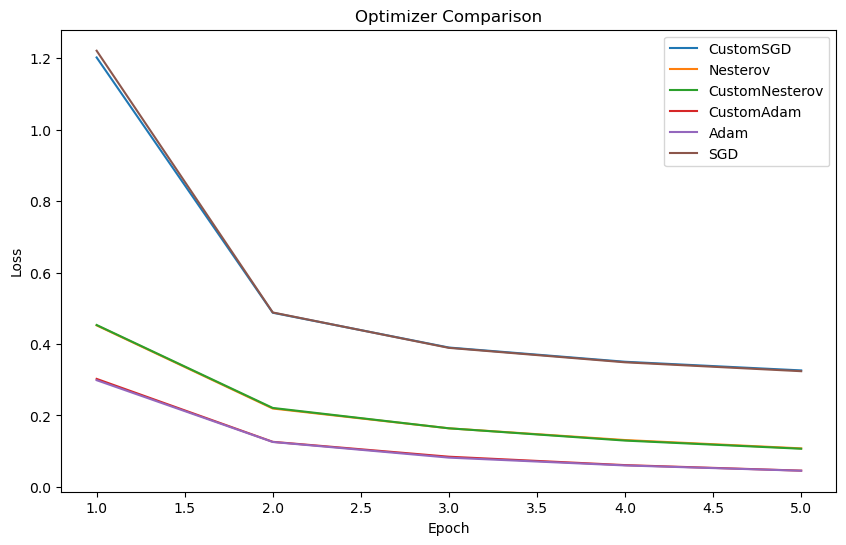

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
import numpy as np

# Fix random seed for reproducibility
def set_seed(seed=42):
    """
    Fix the seed for reproducibility. This ensures that the results are the same across runs.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Custom SGD Optimizer
class CustomSGD(optim.Optimizer):
    def __init__(self, params, lr=0.01):
        """
        Custom SGD Optimizer initialization.
        Args:
            params: Parameters to optimize.
            lr: Learning rate.
        """
        defaults = {'lr': lr}
        super(CustomSGD, self).__init__(params, defaults)

    def step(self):
        """
        Performs one optimization step.
        Updates the parameters by subtracting the gradient scaled by learning rate.
        """
        for group in self.param_groups:
            lr = group['lr']
            for param in group['params']:
                if param.grad is None:
                    continue
                # Update parameters using gradient and learning rate
                param.data -= lr * param.grad.data

# Custom Nesterov Optimizer
class CustomNesterov(optim.Optimizer):
    def __init__(self, params, lr=0.01, momentum=0.9):
        """
        Custom Nesterov Optimizer initialization.
        Args:
            params: Parameters to optimize.
            lr: Learning rate.
            momentum: Momentum factor.
        """
        defaults = {'lr': lr, 'momentum': momentum}
        super(CustomNesterov, self).__init__(params, defaults)

    def step(self):
        """
        Performs one optimization step.
        Updates momentum and parameters according to Nesterov's method:
        m_t = beta * m_{t-1} + eta * g_t
        theta_{t+1} = theta_t - beta * m_t - eta * g_t
        """
        for group in self.param_groups:
            lr = group['lr']
            momentum = group['momentum']

            for param in group['params']:
                if param.grad is None:
                    continue

                state = self.state[param]
                if 'velocity' not in state:
                    state['velocity'] = torch.zeros_like(param.data)
                velocity = state['velocity']

                # Update momentum: m_t = beta * m_{t-1} + eta * g_t
                grad = param.grad.data
                velocity.mul_(momentum).add_(grad, alpha=lr)

                # Update parameter: theta_{t+1} = theta_t - beta * m_t - eta * g_t
                param.data -= velocity * momentum + lr * grad

# Custom Adam Optimizer
class CustomAdam(optim.Optimizer):
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8):
        """
        Custom Adam Optimizer initialization.
        Args:
            params: Parameters to optimize.
            lr: Learning rate.
            betas: Coefficients for computing running averages of gradient and its square.
            eps: A small value to prevent division by zero.
        """
        defaults = {'lr': lr, 'betas': betas, 'eps': eps}
        super(CustomAdam, self).__init__(params, defaults)

    def step(self):
        """
        Performs one optimization step.
        Updates parameters using running averages of the gradient and squared gradient,
        correcting the bias towards zero in the first few time steps.
        """
        for group in self.param_groups:
            lr = group['lr']
            beta1, beta2 = group['betas']
            eps = group['eps']

            for param in group['params']:
                if param.grad is None:
                    continue

                state = self.state[param]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(param.data)
                    state['exp_avg_sq'] = torch.zeros_like(param.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                state['step'] += 1

                grad = param.grad.data

                # Update the running averages of the gradient and squared gradient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # Bias correction
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                # Compute step size
                step_size = lr * (bias_correction2 ** 0.5) / bias_correction1
                param.data -= step_size * exp_avg / (exp_avg_sq.sqrt() + eps)

# Define a simple neural network model
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        # Define a simple fully connected network
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # Flatten the input image
        x = x.view(-1, 28*28)
        # Apply ReLU activation and pass through the network
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Data loading and preprocessing
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training function definition
def train(model, optimizer, epochs=5):
    """
    Train the model for a given number of epochs.
    """
    criterion = nn.CrossEntropyLoss()  # Loss function
    model.train()  # Set the model to training mode
    loss_history = []  # Store loss history for plotting
    for epoch in range(epochs):
        epoch_loss = 0.0
        for data, target in train_loader:
            optimizer.zero_grad()  # Zero the gradients before the backward pass
            output = model(data)  # Forward pass
            loss = criterion(output, target)  # Compute loss
            loss.backward()  # Backward pass (compute gradients)
            optimizer.step()  # Optimize the model's parameters
            epoch_loss += loss.item()  # Accumulate loss
        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)  # Record average loss for this epoch
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')
    return loss_history

# Initialize the optimizers
optimizers = {
    'CustomSGD': CustomSGD,
    'Nesterov': optim.SGD,  # Use PyTorch's SGD with Nesterov (nesterov=True)
    'CustomNesterov': CustomNesterov,
    'CustomAdam': CustomAdam,
    'Adam': optim.Adam,  # PyTorch default Adam
    'SGD': optim.SGD,  # PyTorch default SGD
}

# Store loss histories for each optimizer
loss_histories = {}

# Fix random seed for reproducibility
set_seed()

# Train for each optimizer and track loss
for name, opt_class in optimizers.items():
    print(f'\nTraining with {name}')
    model = SimpleNet()
    
    # Choose the appropriate optimizer
    if name == 'Nesterov':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)  # PyTorch Nesterov
    elif name == 'CustomNesterov':
        optimizer = opt_class(model.parameters(), lr=0.01, momentum=0.9)
    elif name == 'CustomSGD':
        optimizer = opt_class(model.parameters(), lr=0.01)
    elif name == 'CustomAdam':
        optimizer = opt_class(model.parameters(), lr=0.001)
    elif name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    
    # Train the model and store the loss history
    loss_history = train(model, optimizer, epochs=5)
    loss_histories[name] = loss_history

# Plot the results
plt.figure(figsize=(10,6))
for name, loss_history in loss_histories.items():
    plt.plot(range(1, len(loss_history)+1), loss_history, label=name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Optimizer Comparison')
plt.legend()
plt.show()
